<a href="https://colab.research.google.com/github/Pratch-yani/Face_Shape_Classification/blob/main/1_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Capstone Project:  Face Shape Classification - Part 1

This notebook consists of the following processes:
- Define the Problem Statement
- Gather Data
- Explore Data
- Prepare and save the first set of data for modelling

## Problem Statement

Based on [The Deloitte Consumer Review](https://www2.deloitte.com/content/dam/Deloitte/ch/Documents/consumer-business/ch-en-consumer-business-made-to-order-consumer-review.pdf), consumers are demanding more personalised experience, however there is still an unmet need in some categories.  Over 40% of adults aged 16-39 are interested in personalised beauty products and fashion accessories/jewelry, while trial remains low (only 10% and 14% respectively).  Among those who are interested in personalised products for these 2 categories, around 80% are willing to pay premium price (10% or more). 

By being able to classify face shapes, brands will be able to offer more personalised solutions to better satisfy their consumers, while increasing margin from premium positioning.  Example of use cases are:
- Customised face mask [3D Printed Mask](https://www.red-dot.org/project/iope-tailored-solution-40454)
- Customised make-up tips based on face shape [vdo](https://www.youtube.com/watch?v=ZeJP_2IM-2Q)
- Recommendations for glasses or sunglasses
- Recommendations for accessories (i.e. earrings)

For this project, we will be using Deep Learning approach with Convolutional Neural Networks to classify 5 different female face shapes (Heart, Oblong, Oval, Round, Square).  The model that was highest accuracy score will be chosen.

## Import Libaries & Define initial functions

In [ ]:
import matplotlib.pyplot as plt 
import numpy as np 
import os 
import cv2
from skimage.filters.rank import entropy
from skimage.morphology import disk
from skimage.filters import gaussian, sobel, scharr
from skimage.feature import canny
import random
import tensorflow as tf
from tensorflow.keras import utils
import pandas as pd
import seaborn as sns
import pickle


%matplotlib inline

In [ ]:
def show_img(num, img_array, title, ncols=1):
    '''this function display images as is - before any pre-processing'''
    ncols= ncols
    nrows= int(num/ncols)
    fig, ax = plt.subplots(nrows, ncols, figsize =(ncols*4,nrows*4))
    fig.suptitle(title, size = 20)
    ax = ax.ravel()
    for i in range(num):
        ax[i].imshow(img_array[i][0], cmap='gray')
        ax[i].set_title(label_map.get(img_array[i][1]), size=16)



In [ ]:
def subplot_images(num, df, img_index, title, ncols=4, target_w=224, target_h=224):
    '''this function shows images from a dataframe with index - together with cropped & resized function'''
    ncols = ncols
    nrows=int(num/ncols)
    fig, ax = plt.subplots(nrows, ncols, figsize=(ncols*4,nrows*4),sharex=True, sharey=True)
    fig.suptitle(title, size = 20)
    ax = ax.ravel() 
    for i,img in enumerate(img_index):
        image = df.loc[img,'img_array']
        new_image = crop_and_resize(image, target_w=target_w, target_h=target_h)
        ax[i].imshow(new_image, cmap='gray')
        ax[i].set_title(df.loc[img,'face_shape'], size=16)


In [ ]:
def subplot_img_array(num, img_array, title, ncols=4, target_w=224, target_h=224):
    '''this function shows images from an array dataset - together with cropped & resized function'''
    ncols = ncols
    nrows=int(num/ncols)
    fig, ax = plt.subplots(nrows, ncols, figsize=(ncols*4,nrows*4),sharex=True, sharey=True)
    fig.suptitle(title, size = 20)
    ax = ax.ravel() 
    for i,img in enumerate(img_array):
        image = img_array[i][0]
        new_image = crop_and_resize(image, target_w=target_w, target_h=target_h)
        ax[i].imshow(new_image, cmap='gray')
        ax[i].set_title(label_map.get(img_array[i][1]), size=16)


In [ ]:
# print summaries:
def print_summary(train_array, test_array):
    print(f'\nTraining Dataset:\n')
    print(f'Shape: {train_array.shape}')
    print(f'Classes: {np.unique(train_array[:,1])}')
    print(f'No. of Images in each class: {np.bincount(train_array[:,1].astype(int))}')
    print(f'Max Pixels: {np.amax(train_array[0][0][:])}')
    print('\n--------------------------------------\n')
    print(f'\nTesting Dataset:\n')
    print(f'Shape: {test_array.shape}')
    print(f'Classes: {np.unique(test_array[:,1])}')
    print(f'No. of Images in each class: {np.bincount(test_array[:,1].astype(int))}')
    print(f'Max Pixels: {np.amax(test_array[0][0][:])}')
    print('\n--------------------------------------\n')

## Gather Data - Images for Train & Test

Data Sources:

The [Face Shape Dataset](https://www.kaggle.com/niten19/face-shape-dataset) is a dataset from Kaggle by Niten Lama. 

This dataset comprises a total of 5000 images of the female celebrities from all around the globe which are categorized according to their face-shape namely: 
- Heart
- Oblong
- Oval 
- Round
- Square

Each category consists of 1000 images (800 train : 200 test)




In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
train_dir = '/content/drive/My Drive/Colab Notebooks/Face_Shape_Classification/data_face_shape/training_set'
test_dir = '/content/drive/My Drive/Colab Notebooks/Face_Shape_Classification/data_face_shape/testing_set'
example_dir = '/content/drive/My Drive/Colab Notebooks/Face_Shape_Classification/data_face_shape/examples'
categories = ['Heart','Oblong','Oval','Round','Square']

In [ ]:
label_map = {0:'Heart', 1: 'Oblong', 2: 'Oval', 3: 'Round', 4: 'Square'}


In [ ]:
def create_data_files(directory, array, resize=None):
    '''this function reads the images from the directory and create training & testing datasets'''
    i=0
    for category in categories:
        path = os.path.join(directory, category)  # path to directory of images
        class_num = categories.index(category)  # assign number to the 5 categories
        img_list = os.listdir(path)
        try:
            for img in img_list:            
                img_array = cv2.imread(os.path.join(path,img), cv2.IMREAD_GRAYSCALE)
                if resize != None:
                  img_array = cv2.resize(img_array, resize)
                array.append([img_array, class_num])
                i += 1
        except Exception as e:
                print(f'Error: \n category: {category}\n image: {img}')
    
        # Print progress every 400 images
        if i % 200 == 0:
            print(f"Images processed: {i} of {len(img_list*len(categories))}")

In [ ]:
# create training & testing data into a list

training_data = []
testing_data = []

create_data_files(train_dir, training_data)
create_data_files(test_dir, testing_data)

# convert them to numpy arrays

training_data = np.asarray(training_data)
testing_data = np.asarray(testing_data)

Images processed: 800 of 4000
Images processed: 1600 of 4000
Images processed: 2400 of 4000
Images processed: 3200 of 4000
Images processed: 4000 of 4000
Images processed: 200 of 1000
Images processed: 400 of 1000
Images processed: 600 of 1000
Images processed: 800 of 1000
Images processed: 1000 of 1000


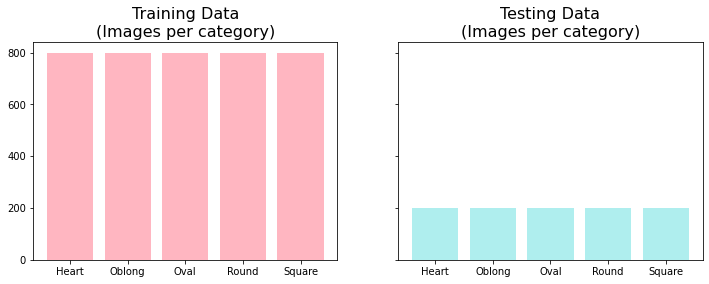

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,4),sharex=True, sharey=True)
ax[0].bar(x=categories, height = np.bincount(training_data[:,1].astype(int)),color='lightpink')
ax[0].set_title('Training Data\n(Images per category)', size=16)
ax[1].bar(x=categories, height = np.bincount(testing_data[:,1].astype(int)),color='paleturquoise')
ax[1].set_title('Testing Data\n(Images per category)', size=16)
ax[1].set_yticks(range(0,801,200));

### Summarize Data and Display sample images

In [ ]:
print_summary(training_data, testing_data)


Training Dataset:

Shape: (4000, 2)
Classes: [0 1 2 3 4]
No. of Images in each class: [800 800 800 800 800]
Max Pixels: 255

--------------------------------------


Testing Dataset:

Shape: (1000, 2)
Classes: [0 1 2 3 4]
No. of Images in each class: [200 200 200 200 200]
Max Pixels: 255

--------------------------------------



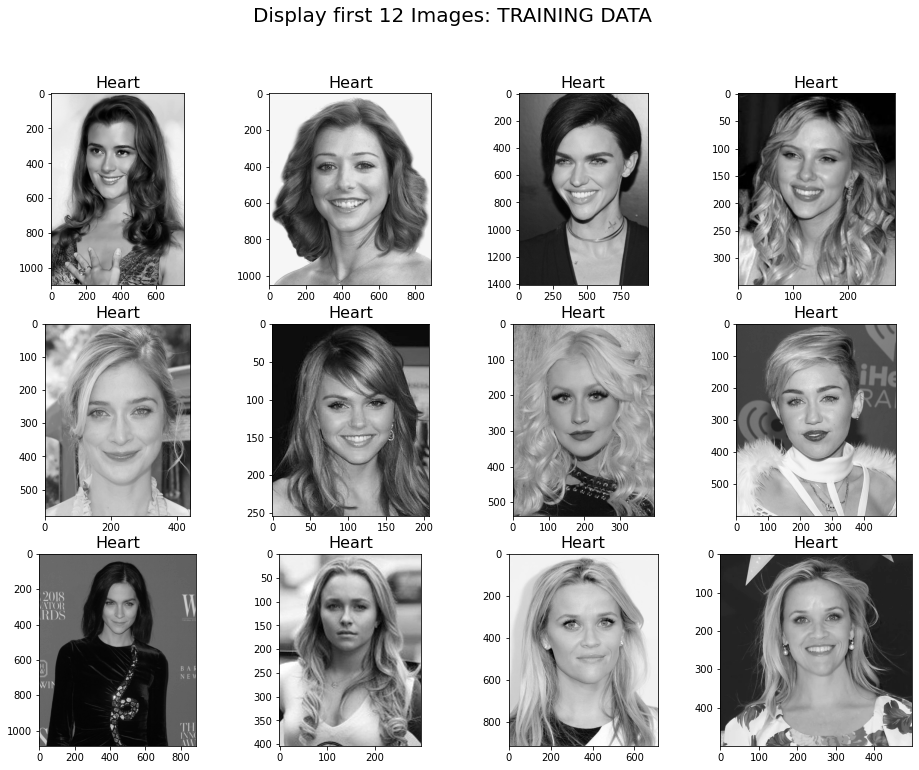

In [ ]:
show_img(12, training_data[:12], 'Display first 12 Images: TRAINING DATA', ncols=4)

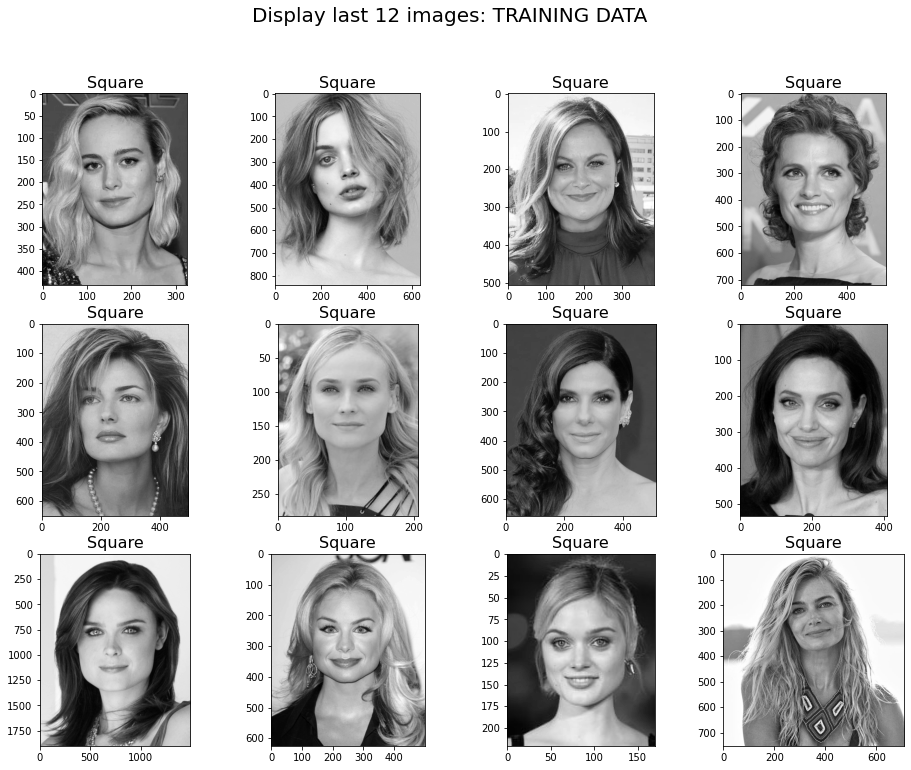

In [ ]:
show_img(12, training_data[len(training_data)-12:], 'Display last 12 images: TRAINING DATA', ncols=4)

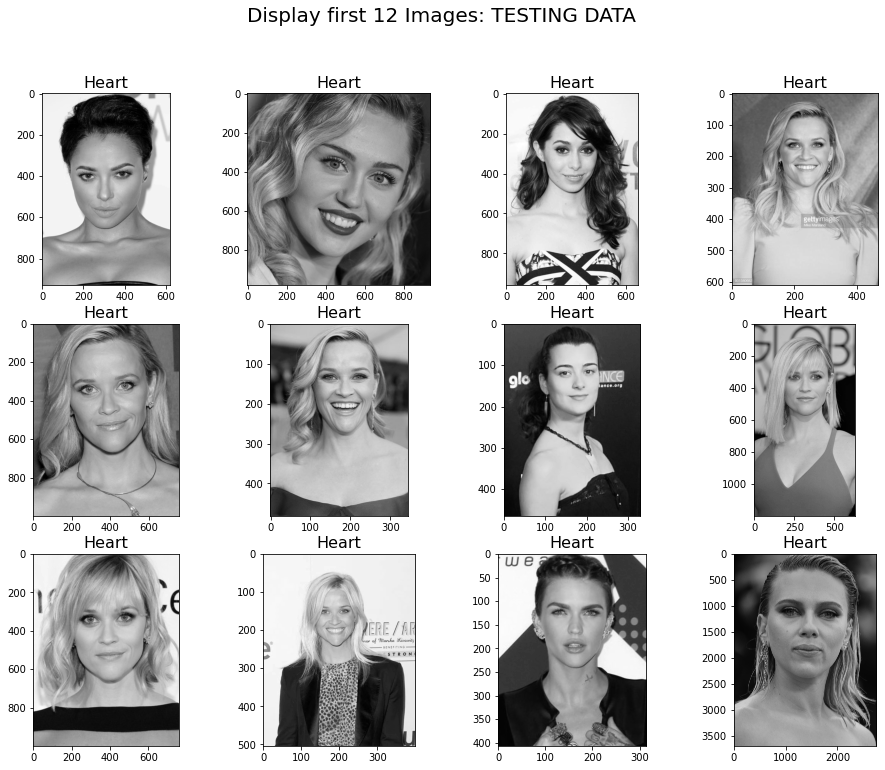

In [ ]:
show_img(12, testing_data[:12], 'Display first 12 Images: TESTING DATA', ncols=4)

## Exploratory Data Analysis

The images are in different sizes, so we need to resize all the images to be the same before we can run a model.  Common input sizes for CNN are as follows:  
   - VGG16 and Resnet50 : 224 x 224 x 3
   - Inception V3 : 299 x 299 x 3



### Let's analyse all the image sizes and their aspect ratios before we resize them

In [ ]:
# Add all the image shapes into an array

shape = []

for image, label in training_data:
    try:
        img_shape = image.shape
        shape.append(img_shape)
    except AttributeError:
        print("shape not found")

shape[:5]

[(1099, 758), (1052, 889), (1409, 949), (350, 286), (579, 440)]

In [ ]:
# Create a data frame with the images and their shapes

train = pd.DataFrame(training_data, columns=['img_array','class'])
train['img_shape'] = pd.Series(shape)
train['face_shape'] = train['class'].map(label_map) 
train.head(2)

,img_array,class,img_shape,face_shape
0,"[[239, 239, 239, 239, 239, 239, 239, 239, 238,...",0,"(1099, 758)",Heart
1,"[[246, 246, 246, 246, 246, 246, 246, 246, 246,...",0,"(1052, 889)",Heart


#### When we sort the images by size, there seems to be variations from largest (9999, 6659) to smallest (159,112)

In [ ]:
train.sort_values(by='img_shape', ascending=False)

,img_array,class,img_shape,face_shape
3037,"[[180, 185, 191, 197, 201, 204, 208, 211, 213,...",3,"(9999, 6659)",Round
606,"[[160, 162, 161, 159, 159, 161, 162, 160, 164,...",0,"(5000, 3333)",Heart
1342,"[[179, 179, 179, 178, 178, 177, 177, 177, 179,...",1,"(4752, 3168)",Oblong
1398,"[[184, 184, 184, 184, 184, 184, 184, 184, 181,...",1,"(4752, 3168)",Oblong
3013,"[[239, 239, 238, 238, 238, 238, 239, 239, 236,...",3,"(4493, 3267)",Round
...,...,...,...,...
2759,"[[239, 239, 239, 239, 239, 239, 239, 239, 239,...",3,"(175, 146)",Round
2933,"[[179, 177, 178, 180, 181, 179, 179, 180, 180,...",3,"(174, 130)",Round
1316,"[[239, 239, 238, 238, 238, 238, 237, 237, 236,...",1,"(174, 127)",Oblong
2682,"[[138, 139, 140, 140, 140, 140, 140, 140, 141,...",3,"(168, 113)",Round


In [ ]:
# Check the info, make sure there are no null values

train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   img_array   4000 non-null   object
 1   class       4000 non-null   object
 2   img_shape   4000 non-null   object
 3   face_shape  4000 non-null   object
dtypes: object(4)
memory usage: 125.1+ KB


#### Let's futher explore image sizes

In [ ]:
# Create Height, Width, and Aspect Ratio for further analysis

train['height'] = train['img_shape'].map(lambda x : x[0])
train['width'] = train['img_shape'].map(lambda x : x[1])
train['aspect_ratio'] = train['width'] / train['height']
train

,img_array,class,img_shape,face_shape,height,width,aspect_ratio
0,"[[239, 239, 239, 239, 239, 239, 239, 239, 238,...",0,"(1099, 758)",Heart,1099,758,0.689718
1,"[[246, 246, 246, 246, 246, 246, 246, 246, 246,...",0,"(1052, 889)",Heart,1052,889,0.845057
2,"[[88, 87, 87, 86, 86, 85, 85, 85, 87, 87, 88, ...",0,"(1409, 949)",Heart,1409,949,0.673527
3,"[[27, 23, 19, 17, 18, 19, 19, 19, 18, 19, 20, ...",0,"(350, 286)",Heart,350,286,0.817143
4,"[[102, 105, 110, 114, 119, 125, 131, 135, 138,...",0,"(579, 440)",Heart,579,440,0.759931
...,...,...,...,...,...,...,...
3995,"[[102, 99, 92, 85, 85, 90, 96, 98, 99, 106, 10...",4,"(533, 410)",Square,533,410,0.769231
3996,"[[217, 217, 217, 217, 216, 217, 218, 219, 219,...",4,"(1900, 1492)",Square,1900,1492,0.785263
3997,"[[190, 190, 189, 189, 189, 190, 190, 191, 189,...",4,"(625, 500)",Square,625,500,0.800000
3998,"[[15, 15, 16, 16, 16, 16, 16, 17, 18, 18, 18, ...",4,"(221, 170)",Square,221,170,0.769231


In [ ]:
train.describe()

,height,width,aspect_ratio
count,4000.000000,4000.000000,4000.000000
mean,729.274000,566.387250,0.791859
std,557.634277,415.329658,0.130946
min,159.000000,112.000000,0.504630
25%,400.000000,305.000000,0.718298
50%,567.000000,447.000000,0.765177
75%,853.500000,680.000000,0.822559
max,9999.000000,6659.000000,1.818182


In [ ]:
# Defines a function to plot histograms showing comparative distributions of variables in a dataframe

def subplot_histograms(dataframe, list_of_columns, list_of_titles, list_of_xlabels, list_of_ylabels, 
                       figsize=(10,8), bins = 15,ncols=2,nrows=0, sharex=True, sharey=True, figtitle=None):
    """plot histograms with subplots in matplotlib"""
    if nrows == 0:
        nrows = int(np.ceil(len(list_of_columns)/2)) # Makes sure you have enough rows
    fig, ax = plt.subplots(figsize=figsize, nrows=nrows, ncols=ncols, 
                           sharex=sharex, sharey=sharey) # You'll want to specify your figsize
    fig.suptitle(figtitle, fontsize=16)
    ax = ax.ravel() # Ravel turns a matrix into a vector, which is easier to iterate
    for i, column in enumerate(list_of_columns): # Gives us an index value to get into all our lists
        ax[i].hist(dataframe[column],bins=bins, color='mediumaquamarine') # feel free to add more settings
        ax[i].set_title(list_of_titles[i])# Set titles, labels, etc here for each subplot
        if (i >= (ncols*nrows)/2):
            ax[i].set_xlabel(list_of_xlabels[i])  # only show x labels on bottom ax plots
        if (sharey==True) and (i % ncols == 0):
            ax[i].set_ylabel(list_of_ylabels[i])  # only show y labels on left ax plots
    plt.tight_layout()
    # plt.savefig(f'../plots/{figtitle}.png');

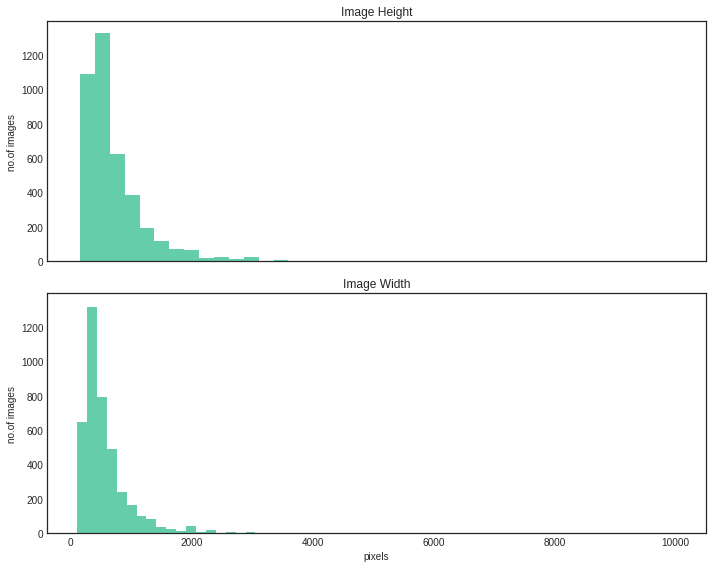

In [ ]:
plt.style.use('seaborn-white')
subplot_histograms(train, ['height', 'width'], 
                   ['Image Height', 'Image Width'], 
                   ['pixels','pixels'], 
                   ['no.of images','no.of images'], 
                   figsize=(10,8), bins = 40,ncols=1,nrows=2, 
                   sharex=True, sharey=True, figtitle=None)

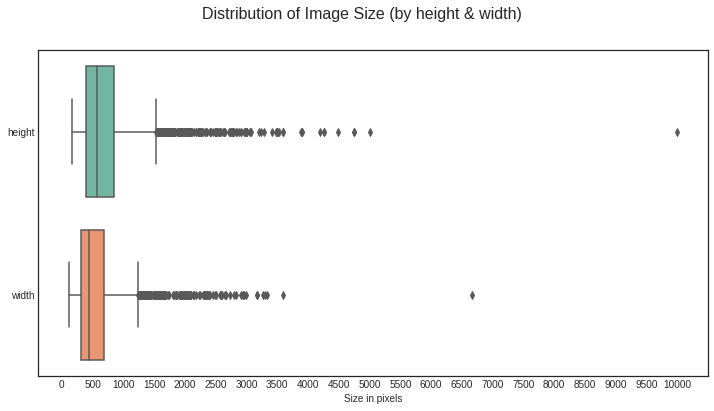

In [ ]:
fig,ax = plt.subplots(figsize=(12,6))
fig.suptitle('Distribution of Image Size (by height & width)', fontsize=16)
sns.boxplot(data=train[['height', 'width']],orient='h', palette='Set2')
ax.set_xlabel('Size in pixels')
ax.set_xticks(range(0,10001, 500));
# sns.stripplot(data=train[['height', 'width']],orient='h', alpha=0.05);



#### Most of the images are small sizes (less than 1000 pixels) with a number of outliers

#### Most of the images are portrait mode with few squares and landscape.  We need to resize them into squares for modelling

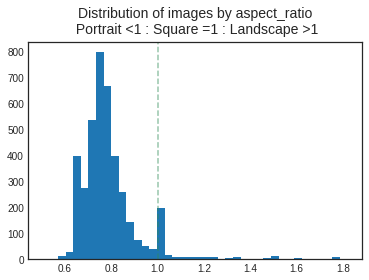

In [ ]:
plt.hist(train['aspect_ratio'],bins=40)
plt.title('Distribution of images by aspect_ratio\n Portrait <1 : Square =1 : Landscape >1', fontsize = 14, y=1.01);
plt.axvline(x=1, alpha=0.5, linestyle='--', color='seagreen');

In [ ]:
fig.suptitle('Image by Aspect Ratio (square=1)')
sns.catplot(data=train, x='aspect_ratio',y='face_shape')
plt.title('Distribution of images by aspect_ratio by face shape\n Portrait <1 : Square =1 : Landscape >1', fontsize = 14, y=1.01);
plt.axvline(x=1, alpha=0.5, linestyle='--', color='seagreen');

### Let's try to see if we resize everything to 224 x 224
The images look a bit distorted, but let's try an initial CNN to see how the model performs.

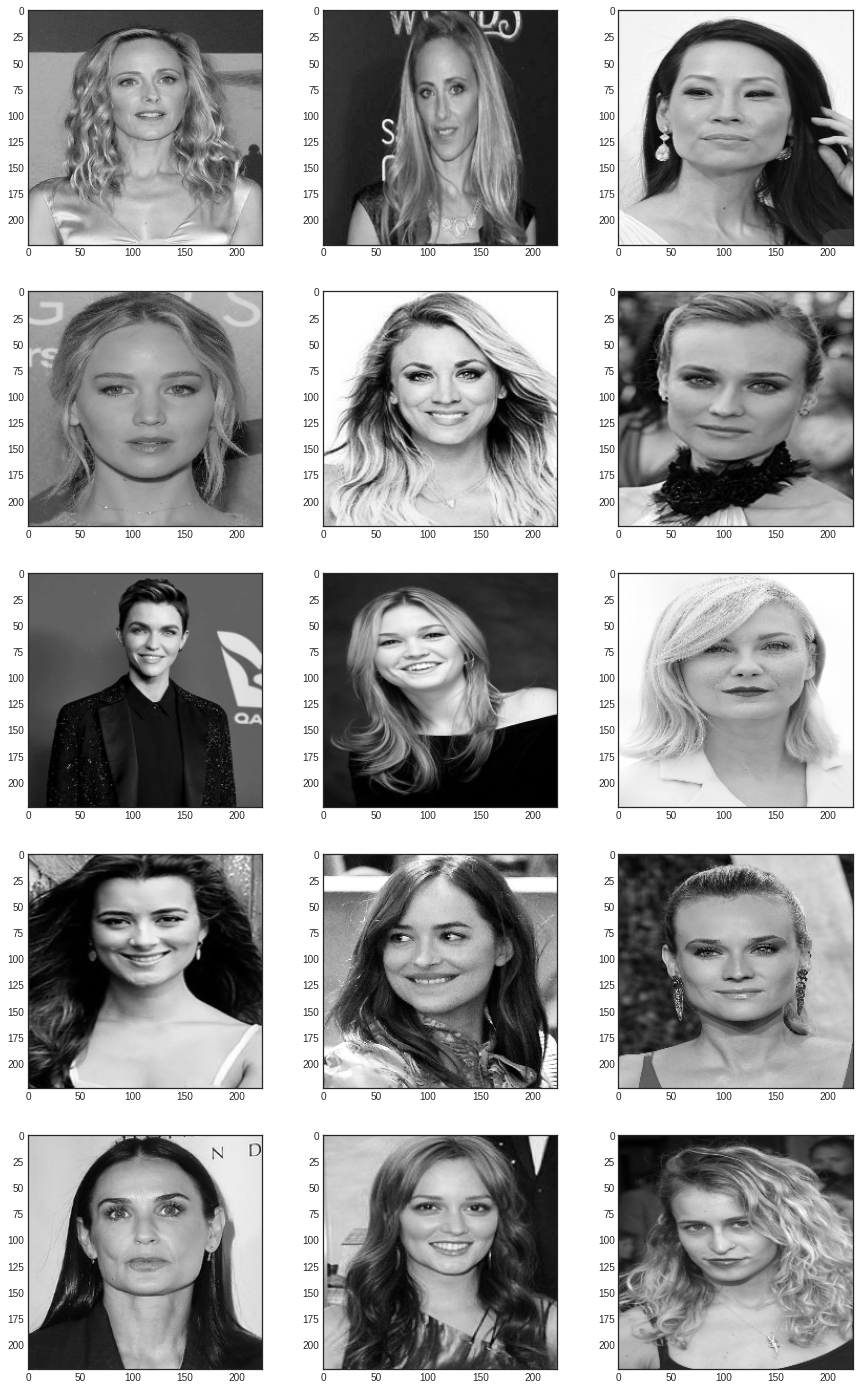

In [ ]:
# let's randomly resize 10 images and see what they look like

randomlist = random.sample(range(0, 3998), 15)
img_size = 224
fig, ax = plt.subplots(nrows = 5, ncols=3, figsize = (15,25))
ax = ax.ravel()
for i,img in enumerate(randomlist):
    image = train.loc[img,'img_array']
    new_image = cv2.resize(image, (img_size, img_size))
    ax[i].imshow(new_image, cmap='gray')

## Prepare Data and Export files for modelling

In [ ]:
def train_test_prep(training_data_array, testing_data_array):
    
    # shuffle the images to mix all the 5 classes randomly
    random.shuffle(training_data_array)
    random.shuffle(testing_data_array)
    
    # read and split X_train, X_test, y_train, y_test into an array
    X_train = []
    y_train = []
    X_test = []
    y_test = []

    for features, label in training_data_array:
        X_train.append(features)
        y_train.append(label)

    for features, label in testing_data_array:
        X_test.append(features)
        y_test.append(label)

    # change data types/format for X
    X_train = np.array(X_train, dtype=float)
    X_test = np.array(X_test, dtype=float)

    X_train = X_train/255
    X_test = X_test/255

    # change values of y to categorical
    y_train = utils.to_categorical(y_train, 5)  
    y_test = utils.to_categorical(y_test, 5)

    return(X_train, X_test, y_train, y_test)

In [ ]:
def pickle_out(X_train, X_test, y_train, y_test, version):
    '''to save the data out for modelling'''
    data_path = '/content/drive/My Drive/Colab Notebooks/Face_Shape_Classification/data/'
    name_xtn = data_path + 'X_train_' + version +'.pickle'
    pickle_out = open(name_xtn,"wb")
    pickle.dump(X_train, pickle_out)
    pickle_out.close()

    name_ytn = data_path + 'y_train_' + version +'.pickle'
    pickle_out = open(name_ytn,"wb")
    pickle.dump(y_train, pickle_out)
    pickle_out.close()

    name_xts = data_path + 'X_test_' + version +'.pickle'
    pickle_out = open(name_xts,"wb")
    pickle.dump(X_test, pickle_out)
    pickle_out.close()

    name_yts = data_path + 'y_test_' + version +'.pickle'    
    pickle_out = open(name_yts,"wb")
    pickle.dump(y_test, pickle_out)
    pickle_out.close()

In [ ]:
# create new training & testing data with resizing

training_data = []
testing_data = []

create_data_files(train_dir, training_data, (224,224))
create_data_files(test_dir, testing_data, (224,224))

Images processed: 800 of 4000
Images processed: 1600 of 4000
Images processed: 2400 of 4000
Images processed: 3200 of 4000
Images processed: 4000 of 4000
Images processed: 200 of 1000
Images processed: 400 of 1000
Images processed: 600 of 1000
Images processed: 800 of 1000
Images processed: 1000 of 1000


In [ ]:
X_train, X_test, y_train, y_test = train_test_prep(training_data, testing_data)

print(f'X_train.shape {X_train.shape}')
print(f'X_test.shape {X_test.shape}')
print(f'y_train.shape {y_train.shape}')
print(f'y_test.shape {y_test.shape}')

In [ ]:
X_train = np.array(X_train).reshape(-1, 224, 224, 1)
X_test = np.array(X_test).reshape(-1, 224, 224, 1)

print(f'X_train.shape {X_train.shape}')
print(f'X_test.shape {X_test.shape}')
print(f'y_train.shape {y_train.shape}')
print(f'y_test.shape {y_test.shape}')

In [ ]:
# need to comment out this part after running this code & generating pickle files
# otherwise it will append to existing file everytime we run it

# pickle_out(X_train, X_test, y_train, y_test, 'r224')

In [ ]:
show_img(12, training_data[:12], 'Display first 12 images: TRAINING DATA', ncols=4)

In [ ]:
show_img(12, testing_data[:12], 'Display first 12 images: TESTING DATA', ncols=4)